In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import scipy

# Custom Modules
import option_data
import sabr_model
import black_scholes_formula
import model_fitting

## Custom Modules

### model_fitting.py

In [ ]:
import numpy as np
import pandas as pd
import scipy
import black_scholes_formula
from scipy.interpolate import UnivariateSpline

def rmse(market, model) -> np.float64:
    return np.sqrt((np.power(market-model, 2)).mean())


class PDF(scipy.stats.rv_continuous):
    def _pdf(self):
        # am thinking could pass an interpolator of RNDs for this...
        pass




class ModelFit(object):

    def __init__(self,  obj_func, intial_guess, bounds, param_names, vol_func):
        """
        :param obj_func: objective function to be passed to Scipy Minimise
        :param intial_guess: initial guess for params of obj function
        :param bounds: bounds for these parameters, an argument of scipy minimise
        :param param_names: just for printing
        """

        self.initial_guess = intial_guess
        self.bounds = bounds
        self.obj_func = obj_func
        self.param_names = param_names
        self.vol_func = vol_func

    def perform_minimisation(self, obj_func_args) -> scipy.optimize._optimize.OptimizeResult:
        result = scipy.optimize.minimize(self.obj_func,
                                         x0=self.initial_guess.copy(),
                                         args=obj_func_args,
                                         bounds=self.bounds)
        self.result = result

        return result

    def fit_cubic_spline(self, calls):
        # kind='cubic', fill_value="extrapolate"
        y = calls.ImpliedVolatility.values
        # vol_function = scipy.interpolate.interp1d(x=calls.Strike.values, y=calls.ImpliedVolatility.values,
        #                                          kind='cubic', fill_value=(y[0], y[-1]), bounds_error=False)
        # #(y[0], y[-1])
        vol_function = UnivariateSpline(x=calls.Strike.values,
                                        y=calls.ImpliedVolatility.values,
                                        k=3,
                                        s=0.05,
                                        ext=3) # ext=3 returns boundary values!

        self.vol_func = vol_function

        return vol_function

    def show_result(self, r=None):
        if r is None:
            r = self.result

        return dict(zip(self.param_names, r.x))

    def calc_call_price_errors(self, call_data, fwd, tenor, rate, vol_func_arg):
        """
        :param call_data: call options for specific date and expiry. e.g. all_1M_wk.loc[date, "C"]
        :return:
        """
        strike_range = call_data.Strike.values
        mkt_prices = call_data.mid.values
        call_prices_interp = np.zeros(len(strike_range))

        for i, strike in enumerate(strike_range):
            vol_func_arg["K"] = strike
            call_price_interp = black_scholes_formula.black_scholes_call(S=fwd, K=strike,
                                                                         t=tenor,
                                                                         sigma=self.vol_func(**vol_func_arg),
                                                                         r=rate)
            call_prices_interp[i] = call_price_interp
        error_pct = (call_prices_interp-mkt_prices)/mkt_prices

        return error_pct

    def check_butterflies(self, calls):
        data = []
        for (_, left), (_, centre), (_, right) in zip(calls.iterrows(), calls.iloc[1:].iterrows(),
                                                      calls.iloc[2:].iterrows()):
            if centre.Strike - left.Strike != right.Strike - centre.Strike:
                continue
            butterfly_price = left.mid - 2 * centre.mid + right.mid
            max_profit = centre.Strike - left.Strike
            data.append([centre.Strike, butterfly_price, max_profit])

        bflys = pd.DataFrame(data, columns=["strike", "price", "max_profit"])
        bflys["prob"] = bflys.price / bflys.max_profit
        return bflys

    def get_model_calls(self, krange,fwd, tenor, rate, vol_func_arg):
        call_prices_interp = np.zeros(len(krange))
        for i, strike in enumerate(krange):
            vol_func_arg["K"] = strike
            call_price_interp = black_scholes_formula.black_scholes_call(S=fwd, K=strike,
                                                                         t=tenor,
                                                                         sigma=self.vol_func(**vol_func_arg),
                                                                         r=rate)
            call_prices_interp[i] = call_price_interp
        return call_prices_interp

    def construct_pdf(self, min_strike, max_strike, fwd, tenor, rate, vol_func_arg):
        k_new = np.arange(start=min_strike, stop=max_strike, step=1)
        # unfortuntaely for now will have to loop: # should store this as attribute for later use
        call_prices_interp = np.zeros(len(k_new))  # Allocate all memory first
        for i, strike in enumerate(k_new):
            vol_func_arg["K"] = strike
            call_price_interp = black_scholes_formula.black_scholes_call(S=fwd, K=strike,
                                                                         t=tenor,
                                                                         sigma=self.vol_func(**vol_func_arg),
                                                                         r=rate)

            call_prices_interp[i] = call_price_interp
        first_deriv = np.gradient(call_prices_interp, k_new, edge_order=0)
        second_deriv = np.gradient(first_deriv, k_new, edge_order=0)
        densities = np.exp(-rate*tenor)*second_deriv
        return densities

    def construct_pdf_cubic(self, min_strike, max_strike, fwd, tenor, rate):
        k_new = np.arange(start=min_strike, stop=max_strike, step=1)
        call_prices_interp = black_scholes_formula.black_scholes_call(S=fwd,
                                                                     K=k_new,
                                                                     sigma=self.vol_func(k_new),
                                                                     t=tenor, r=rate)

        first_deriv = np.gradient(call_prices_interp, k_new, edge_order=0)
        second_deriv = np.gradient(first_deriv, k_new, edge_order=0)
        densities = np.exp(-rate*tenor)*second_deriv
        return densities

    def calc_call_price_errors_cubic(self, call_data, fwd, tenor, rate):
        strike_range = call_data.Strike.values
        mkt_prices = call_data.mid.values
        call_prices_interp = black_scholes_formula.black_scholes_call(S=fwd,
                                                                      K=strike_range,
                                                                      sigma=self.vol_func(strike_range),
                                                                      t=tenor, r=rate)

        error_pct = (call_prices_interp - mkt_prices) / mkt_prices
        return error_pct

    def get_model_calls_cubic(self, krange, fwd, tenor, rate):
        call_prices_interp = black_scholes_formula.black_scholes_call(S=fwd,
                                                                      K=krange,
                                                                      sigma=self.vol_func(krange),
                                                                      t=tenor,
                                                                      r=rate)
        return call_prices_interp


### option_data.py

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

# sp500_path = '.\Resources\Stock and Index Options\SP500 Option.csv'
sp500_path = '/Users/cahalmurphy/Documents/UCD Files/Stage 4/Semester_2/FIN30190 - Financial Economics II/Project_B/Resources/Stock and Index Options/SP500 Option.csv'

data_path = './Data/data.csv'

# equity_path = '.\Resources\Stock and Index Options\SA9.csv'

headers = ['Date', 'SecurityID', 'SecurityPrice', 'TotalReturn', 'AdjustmentFactor', 'AdjustmentFactor2',
           'InterestRate' ,'Expiration' ,'Strike' ,'OptionID', 'CallPut', 'BestBid', 'BestOffer', 'ImpliedVolatility',
           'Delta', 'Gamma', 'Vega', 'Theta']

dtypes = {'Date': str,
          'SecurityID': int,
          'SecurityPrice': np.float32,
          'TotalReturn': np.float32,
          'AdjustmentFactor': int,
          'AdjustmentFactor2': np.float32,
          'InterestRate': np.float32,
          'Expiration': str,
          'Strike': np.float32,
          'OptionID': int,
          'CallPut': str,
          'BestBid': np.float32,
          'BestOffer': np.float32,
          'ImpliedVolatility': np.float32,
          'Delta': np.float32,
          'Gamma': np.float32,
          'Vega': np.float32,
          'Theta': np.float32,
          }




def _dateparser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


def get_data(path: str = sp500_path):
    sp500_data = pd.read_csv(filepath_or_buffer=path, header=None, names=headers,
                             dtype=dtypes,
                             na_values=np.float32(-99.99),
                             parse_dates=['Date', 'Expiration'], date_parser=_dateparser,
                             )

    data = sp500_data.copy()
    # NA Values from CSV file
    nan_number = np.float32(-99.99)
    data = data.replace(nan_number, np.NaN)

    data['Strike'] = data['Strike'] / 1000
    data = data.set_index(['Date', 'CallPut', 'Expiration', 'Strike'], drop=False)
    data = data.sort_index()

    # Columns Editing
    data["tau"] = (data["Expiration"] - data["Date"]).dt.days / 252
    data["mid"] = (data["BestBid"] + data["BestOffer"]) / 2
    data["InterestRate"] /= 100

    return data


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


def get_ATM_option(options, delta_value=0.5):
    """
    # Make sure to set Delta to -0.5 for PUTS *********
    """
    if options.CallPut.iloc[0] == 'C' and delta_value < 0:
        print("Negative Delta_Value for finding ATM CALLS")
    if options.CallPut.iloc[0] == 'P' and delta_value > 0:
        print("Positive Delta_Value for finding ATM PUTS")

    delta, index = find_nearest(options.Delta.values, delta_value)

    return options.index[index]  # will be the strike of nearest Delta to 0.5


def get_test_df():
    test_strikes = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
    test_vols = [45.6, 41.6, 37.9, 36.6, 37.8, 39.2, 40.0]
    test_df = pd.DataFrame(index=test_strikes, columns=["Strike", "IV"],
                           data={'Strike': test_strikes, 'ImpliedVolatility': test_vols})
    test_df /= 100
    test_df.index /= 100
    return test_df


### black_scholes_formula.py

In [ ]:
import numpy as np
import scipy
from scipy.stats import norm


def black_scholes_call(S, K, sigma, t=0, r=0):
    d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

# Notebook 

In [3]:
data = option_data.get_data()

In [4]:
test_df = option_data.get_test_df()

In [5]:
import os
"""  Plots Formatting  """
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


sns.set(font='Verdana',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'grey',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":12,
                                "axes.titlesize":20,
                                "axes.labelsize":12})

# sns.despine(left=True, bottom=True)
# plt.legend(frameon=False)
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 1
colours = ["firebrick", "orange", "forestgreen", "purple", "dodgerblue", "olive", "crimson", "lime", "cyan", "slategray"]

output_folder = os.path.join(os.getcwd(), "Output")

isExist = os.path.exists(output_folder)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(output_folder)
    print("The new directory is created!\n", output_folder)

sub_text = "MSc RMFE - Applied Project - Cahal Murphy"

### Q: No. of Calls Quotes vs No. of Puts Quoted on each day!

In [11]:
data.loc[:, 'spread'] = (data.BestOffer-data.BestBid)/data.mid

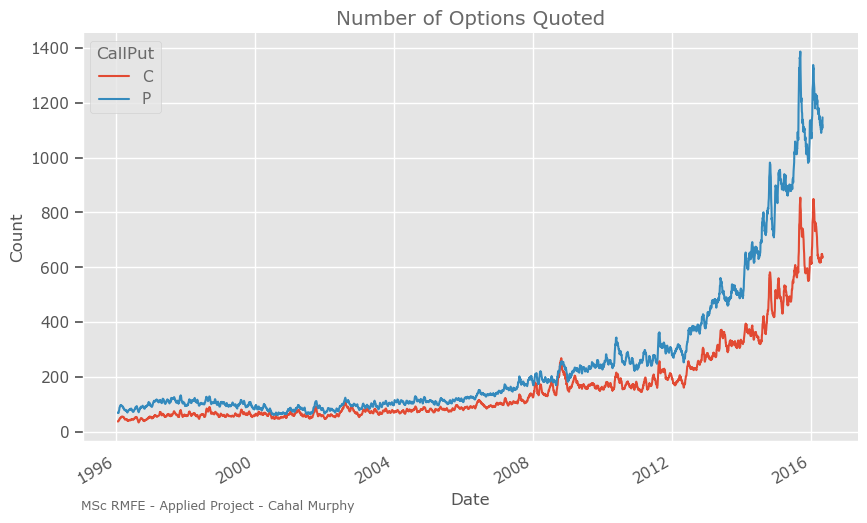

In [12]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.reset_index(drop=True).groupby(["Date", "CallPut"]).agg(Count=pd.NamedAgg('ImpliedVolatility', aggfunc='count')).reset_index().pivot(index='Date', columns='CallPut', values='Count').rolling(14).mean().plot(ax=ax)

    #index='patient', columns='obs', values='score'
    ax.set_title("Number of Options Quoted")
    fig.text(0.26, 0.085, sub_text,
             wrap=True, horizontalalignment='center', fontsize=9);
    ax.set_ylabel("Count")
    plt.savefig(os.path.join(output_folder, "QuoteCount.png"), bbox_inches="tight")

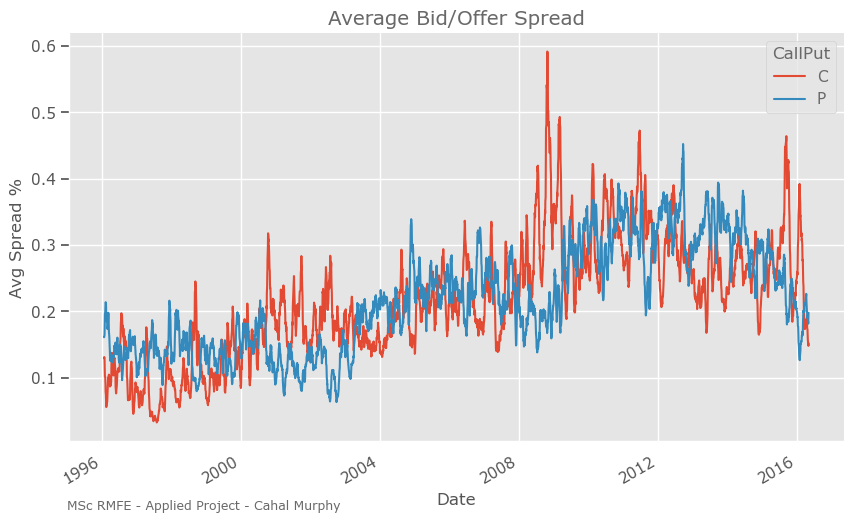

In [13]:
# Average Spread could be a function of the quoting of a broader range of Strikes...
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.reset_index(drop=True).groupby(["Date", "CallPut"]).agg(avgspread=pd.NamedAgg('spread', aggfunc='mean')).reset_index().pivot(index='Date', columns='CallPut', values='avgspread').rolling(14).mean().plot(ax=ax)

    ax.set_title("Average Bid/Offer Spread")
    fig.text(0.26, 0.085, sub_text,
             wrap=True, horizontalalignment='center', fontsize=9);
    ax.set_ylabel("Avg Spread %")
    plt.savefig(os.path.join(output_folder, "AvgSpread.png"), bbox_inches="tight")


### Running this for a range of dates

In [14]:
date_range = data.Date.unique()
tau_2Wk = 14/252
wiggle = 2/252

fitSABR = model_fitting.ModelFit(obj_func=sabr_model.objective_func_sabr,
                                 intial_guess=[0.1, 0.2, 0.05],
                                 bounds=((0.001, None), (-0.99, 0.99), (0.001, None)),
                                 param_names=["Alpha", "Rho", "Nu"],
                                 vol_func=sabr_model.SABR)

sabr_result_series = {}
Beta = 1.0
counter = 0
fails = 0
for date in date_range:
    df = data.loc[date, :].copy()
    all_2Wk_df = df[((df.tau >= tau_2Wk-wiggle) & (df.tau <= tau_2Wk+wiggle))]
    # calls = option_data.find_nearest(calls.tau.unique(), tau_2Wk)



    try:
        # need to update to include all Calls and Puts for a given Date... i.e. Puts < ATM and Calls >ATM
        calls = all_2Wk_df.loc["C"]
        closest_tau, _ = option_data.find_nearest(calls.tau.unique(), tau_2Wk)
        calls = calls[calls.tau == closest_tau]
        calls = calls[calls["ImpliedVolatility"].notna()]



        rate = calls.InterestRate.iloc[0]
        tenor = calls.tau.iloc[0]
        fwd = calls.SecurityPrice.iloc[0] * np.exp(rate*tenor)

        r = fitSABR.perform_minimisation(obj_func_args=(Beta, calls.Strike.to_numpy(), calls.ImpliedVolatility.to_numpy(), fwd, tenor))

        date_result = list(r.x)
        date_result.extend([calls.Strike.min(), calls.Strike.max(), tenor, fwd, rate, Beta])

        sabr_result_series[date] = date_result
        counter+=1
    except KeyError as e:
        fails+=1
        pass
print("Total Successes: {} | Total Fails: {}".format(counter, fails))

/Users/cahalmurphy/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Term 3/Applied_Project-2023/Code/sabr_model.py:29: RuntimeWarning: invalid value encountered in log
  x_z = np.log((np.sqrt(1 - 2 * p * z + z ** 2) + z - p) / (1 - p))


Total Successes: 1277 | Total Fails: 3818


In [15]:
df_result = pd.DataFrame(sabr_result_series).T
cols = fitSABR.param_names.copy()
cols.extend(["min_strike", "max_strike", "tenor", "fwd", "rate", "Beta"])
df_result.columns = cols

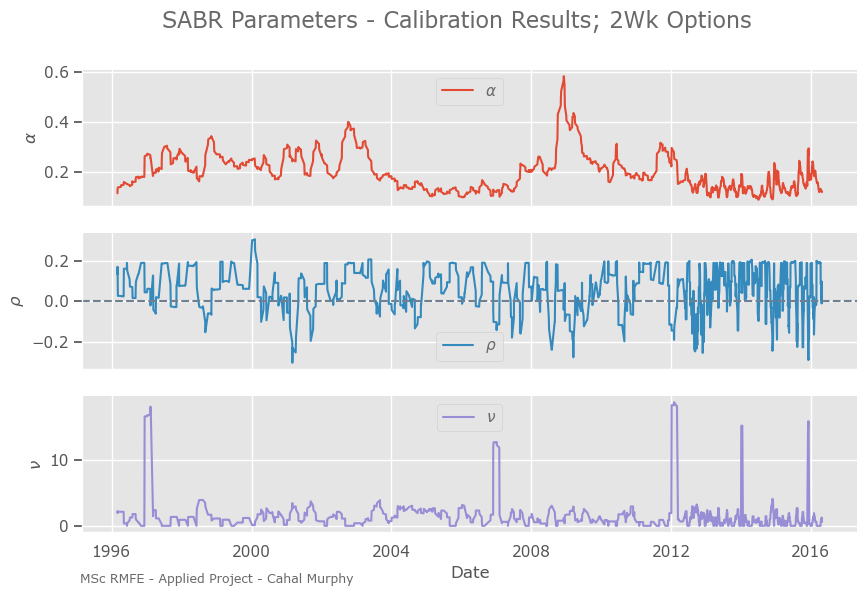

In [16]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(nrows=3, figsize=(10, 6), sharex=True)
    df_result[fitSABR.param_names].rolling(7).mean().plot(subplots=True, ax=ax)
    ax[-1].set_xlabel("Date")
    ax[0].set_ylabel(r"$\alpha$")
    ax[1].set_ylabel(r"$\rho$")
    ax[2].set_ylabel(r"$\nu$")
    ax[0].legend([r"$\alpha$"], loc='upper center')
    ax[1].legend([r"$\rho$"], loc='lower center')
    ax[2].legend([r"$\nu$"], loc='upper center')
    ax[1].axhline(0, ls='--', color='slategrey')
    fig.suptitle("SABR Parameters - Calibration Results; 2Wk Options", fontsize=16)
    fig.text(0.26, 0.025, sub_text,
             wrap=True, horizontalalignment='center', fontsize=9);
    plt.savefig(os.path.join(output_folder, "SABRParams_2Wk.png"), bbox_inches="tight")

### Checks for Arbitrage

* ToDo, reduce strike range to reduce Time Complexity and run-time

In [17]:
for index, row in df_result.iterrows():
    d = fitSABR.construct_pdf(row.min_strike,
                      row.max_strike,
                      row.fwd,
                      row.tenor,
                      row.rate,
                      {"alpha": row.Alpha, "p": row.Rho, "nu": row.Nu, "F": row.fwd, "t": row.tenor,
                       "B": row.Beta})

    date = row.name
    df = data.loc[date, :].copy()
    all_1M_df = df[((df.tau >= tau_2Wk-wiggle) & (df.tau <= tau_2Wk+wiggle))]
    calls = all_1M_df.loc["C"]
    closest_tau, _ = option_data.find_nearest(calls.tau.unique(), tau_2Wk)
    calls = calls[calls.tau == closest_tau]

    calls = calls[calls["ImpliedVolatility"].notna()]

    call_price_error = fitSABR.calc_call_price_errors(call_data=calls,
                                                      fwd=row.fwd,
                                                      tenor=row.tenor,
                                                      rate=row.rate,
                                                      vol_func_arg={"alpha": row.Alpha, "p": row.Rho, "nu": row.Nu, "F": row.fwd, "t": row.tenor,"B": row.Beta})

    # This is with Market Data
    constructed_butterflys = fitSABR.check_butterflies(calls=calls)
    # check if any price is < 0
    total_arbs = len(constructed_butterflys[constructed_butterflys.price < 0].price)
    # Check with SABR Calls Data
    model_calls = fitSABR.get_model_calls(calls.Strike.values,fwd=row.fwd,
                                                      tenor=row.tenor,
                                                      rate=row.rate,
                                                      vol_func_arg={"alpha": row.Alpha, "p": row.Rho, "nu": row.Nu, "F": row.fwd, "t": row.tenor, "B": row.Beta} )
    model_calls = pd.DataFrame(index=calls.index, columns=["mid"], data=model_calls)
    model_calls['Strike'] = calls.Strike
    constructed_butterflys_model = fitSABR.check_butterflies(calls=model_calls)
    total_arbs_model = len(constructed_butterflys_model[constructed_butterflys_model.price < 0].price)



    df_result.loc[index, "RNDArea"] = d.sum()
    df_result.loc[index, "AvgCallPriceError"] = np.mean(call_price_error)
    df_result.loc[index, "btflyArb"] = max(total_arbs_model, 0)




In [18]:
df_result.loc[:, "Year"] = df_result.index.year
df_result.loc[:, "Month"] = df_result.index.month


In [19]:
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "July", 8: "Aug",
             9: "Sept", 10: "Oct", 11: "Nov", 12:"Dec"}

In [20]:
rnd_avg_year_month = df_result.groupby(["Year", "Month"], as_index=False).agg(avgRNDArea=pd.NamedAgg("RNDArea", aggfunc='mean')).pivot(index='Year', columns='Month', values='avgRNDArea')
rnd_avg_year_month.columns = rnd_avg_year_month.columns.map(month_map)

In [21]:
avg_priceerror_yearmonth = df_result.groupby(["Year", "Month"], as_index=False).agg(avgPriceError=pd.NamedAgg("AvgCallPriceError", aggfunc='mean')).pivot(index='Year', columns='Month', values='avgPriceError')
avg_priceerror_yearmonth.columns =avg_priceerror_yearmonth.columns.map(month_map)

In [88]:
# with plt.style.context('ggplot'):
#
#     fig, ax = plt.subplots(figsize=(7,6))
#     sns.heatmap((1-rnd_avg_year_month), annot=False,cmap='coolwarm', linewidths=0.5, ax=ax)
#     plt.title("SABR 2Wk Options - RND Area Error (one minus area) ")
#     fig.text(0.26, 0.01, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     #plt.savefig(os.path.join(output_folder, "SABR_RNDAreaError_2Wk.png"), bbox_inches="tight")
#

In [89]:
# with plt.style.context('ggplot'):
#
#     fig, ax = plt.subplots(figsize=(7,6))
#     sns.heatmap(avg_priceerror_yearmonth, annot=False,cmap='coolwarm', linewidths=0.5, ax=ax)
#     plt.title("SABR 2Wk Options - Avg Call Price Error %")
#     fig.text(0.26, 0.01, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "SABR_CallError_2Wk.png"), bbox_inches="tight")


In [90]:
# with plt.style.context('ggplot'):
#
#     fig, ax = plt.subplots(figsize=(8,6))
#     df_result.btflyArb.plot(ax=ax)
#     plt.title("SABR 2Wk Options - Butterfly Arb")
#     ax.set_ylabel("Count of Butterfly Arbs")
#     ax.set_xlabel("Date")
#     fig.text(0.29, 0.08, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "SABR_btflyArb_2Wk.png"), bbox_inches="tight")


In [26]:
df_result_cubic = pd.DataFrame(sabr_result_series).T
cols = fitSABR.param_names.copy()
cols.extend(["min_strike", "max_strike", "tenor", "fwd", "rate", "Beta"])
df_result_cubic.columns = cols

In [27]:
df_result_cubic = df_result_cubic.drop(['Alpha', 'Rho', 'Nu'], axis=1)

tau_2Wk = 14/252
wiggle = 2/252

fitCubic = model_fitting.ModelFit(obj_func=None,
                                  intial_guess=None,
                                  bounds=None,
                                  param_names=None,
                                  vol_func=None) # vol_func will be assigned in fit_cubic_spline method

In [28]:
df_result_cubic = pd.DataFrame(columns=['min_strike', 'max_strike', 'tenor', 'fwd', 'rate'])

In [91]:
for date in date_range:
    df = data.loc[date, :].copy()
    # print(date)
    all_1M_df = df[((df.tau >= tau_2Wk-wiggle) & (df.tau <= tau_2Wk+wiggle))]
    try:
        best_tau = all_1M_df.reset_index(drop=True).groupby('tau', as_index=False).agg(Count=pd.NamedAgg('ImpliedVolatility', aggfunc='count')).sort_values('Count', ascending=False).iloc[0].tau
        calls = all_1M_df.loc["C"]
        calls = calls[calls.tau == best_tau]
        calls = calls[calls["ImpliedVolatility"].notna()]
    except:
        next
    # pick tau with largest amount of quotes
    #closest_tau, _ = option_data.find_nearest(calls.tau.unique(), tau_2Wk)
    #calls = calls[calls.tau == closest_tau]



    rate = calls.InterestRate.iloc[0]
    tenor = calls.tau.iloc[0]
    fwd = calls.SecurityPrice.iloc[0] * np.exp(rate*tenor)
    try:
        vf_ = fitCubic.fit_cubic_spline(calls)
    except:
        # print(date)
        next
    df_result_cubic.loc[date, :] = [calls.Strike.min(), calls.Strike.max(), tenor, fwd, rate]



ValueError: Must have equal len keys and value when setting with an iterable

In [30]:
for index, row in df_result_cubic.iterrows():
    date = row.name
    df = data.loc[date, :].copy()
    try:
        all_1M_df = df[((df.tau >= tau_2Wk-wiggle) & (df.tau <= tau_2Wk+wiggle))]
        best_tau = all_1M_df.reset_index(drop=True).groupby('tau', as_index=False).agg(Count=pd.NamedAgg('ImpliedVolatility', aggfunc='count')).sort_values('Count', ascending=False).iloc[0].tau
        calls = all_1M_df.loc["C"]
        calls = calls[calls.tau == best_tau]
        calls = calls[calls["ImpliedVolatility"].notna()]
    except:
        next

    # resets the vol_func in fitCUBIC each time
    try:
        vf_ = fitCubic.fit_cubic_spline(calls)

        d = fitCubic.construct_pdf_cubic(row.min_strike,
                          row.max_strike,
                          row.fwd,
                          row.tenor,
                          row.rate)

        date = row.name
        df = data.loc[date, :].copy()


        call_price_error = fitCubic.calc_call_price_errors_cubic(call_data=calls,
                                                                 fwd=row.fwd,
                                                                 tenor=row.tenor,
                                                                 rate=row.rate)

        # This is with Market Data
        constructed_butterflys = fitSABR.check_butterflies(calls=calls)
        # check if any price is < 0
        total_arbs = len(constructed_butterflys[constructed_butterflys.price < 0].price)
        # Check with SABR Calls Data
        model_calls = fitCubic.get_model_calls_cubic(calls.Strike.values,
                                                     fwd=row.fwd,
                                                     tenor=row.tenor,
                                                     rate=row.rate)
        model_calls = pd.DataFrame(index=calls.index, columns=["mid"], data=model_calls)
        model_calls['Strike'] = calls.Strike
        constructed_butterflys_model = fitSABR.check_butterflies(calls=model_calls)

        total_arbs_model = len(constructed_butterflys_model[constructed_butterflys_model.price < 0].price)

        df_result_cubic.loc[index, "RNDArea"] = d.sum()
        df_result_cubic.loc[index, "AvgCallPriceError"] = np.mean(call_price_error)
        df_result_cubic.loc[index, "btflyArb"] = max(total_arbs_model, 0)
    except:
        # print(index)
        next





2007-09-12 00:00:00
2007-09-13 00:00:00
2007-09-14 00:00:00
2007-09-17 00:00:00
2007-09-18 00:00:00
2007-09-19 00:00:00
2007-09-20 00:00:00
2007-09-21 00:00:00
2007-09-24 00:00:00
2007-09-25 00:00:00
2007-09-26 00:00:00
2007-09-27 00:00:00
2007-09-28 00:00:00
2007-10-01 00:00:00
2007-10-02 00:00:00
2007-10-03 00:00:00


In [31]:
df_result_cubic = df_result_cubic[df_result_cubic.RNDArea>0]

In [32]:
df_result_cubic.loc[:, "Year"] = df_result_cubic.index.year
df_result_cubic.loc[:, "Month"] = df_result_cubic.index.month

In [33]:
rnd_avg_year_month.min(axis=1).min()

0.5871717163690134

### Cubic Results

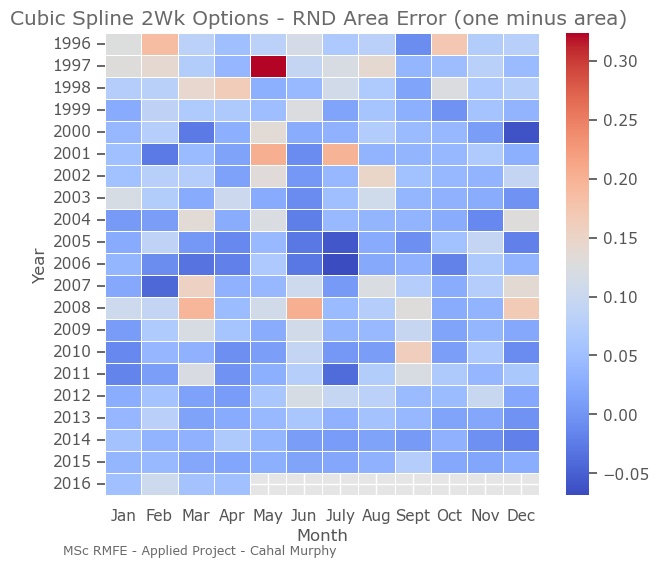

In [34]:
rnd_avg_year_month_cubic = df_result_cubic.groupby(["Year", "Month"], as_index=False).agg(avgRNDArea=pd.NamedAgg("RNDArea", aggfunc='mean')).pivot(index='Year', columns='Month', values='avgRNDArea')
rnd_avg_year_month_cubic.columns = rnd_avg_year_month_cubic.columns.map(month_map)
#rnd_avg_year_month_cubic.loc[2015, "Aug"] /=10
# with plt.style.context('ggplot'):
#     fig, ax = plt.subplots(figsize=(7,6))
#     sns.heatmap((1-rnd_avg_year_month_cubic), annot=False, linewidths=0.5, ax=ax, cmap='coolwarm',
#                 )#vmax=0.8, vmin=-0.8)
#     # vmin=rnd_avg_year_month.min().min(), vmax=rnd_avg_year_month.max().max()
#     plt.title("Cubic Spline 2Wk Options - RND Area Error (one minus area) ")
#     fig.text(0.26, 0.01, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "Cubic_RNDAreaError_2Wk.png"), bbox_inches="tight")


In [35]:
avg_priceerror_yearmonth_cubic = df_result_cubic.groupby(["Year", "Month"], as_index=False).agg(avgPriceError=pd.NamedAgg("AvgCallPriceError", aggfunc='mean')).pivot(index='Year', columns='Month', values='avgPriceError')
avg_priceerror_yearmonth_cubic.columns =avg_priceerror_yearmonth_cubic.columns.map(month_map)

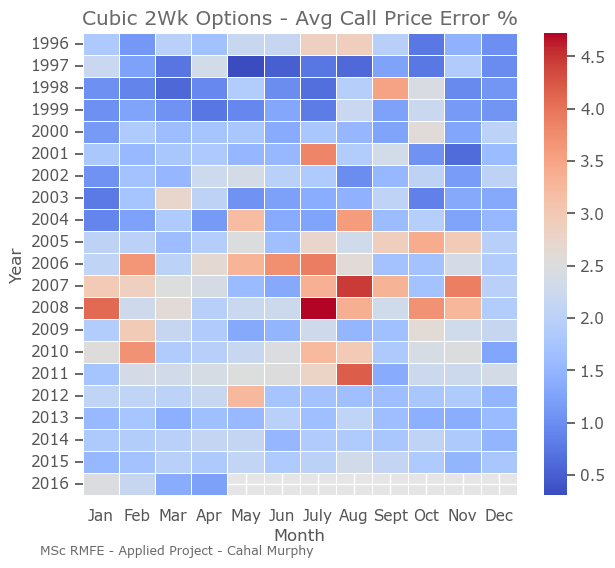

In [36]:
# with plt.style.context('ggplot'):
#     fig, ax = plt.subplots(figsize=(7,6))
#     sns.heatmap(avg_priceerror_yearmonth_cubic, annot=False,cmap='coolwarm', linewidths=0.5, ax=ax)
#     plt.title("Cubic 2Wk Options - Avg Call Price Error %")
#     fig.text(0.26, 0.01, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "Cubic_CallError_2Wk.png"), bbox_inches="tight")


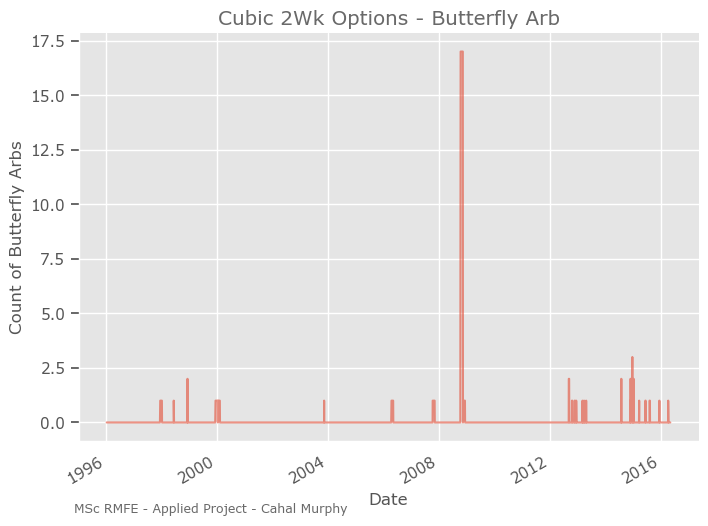

In [37]:
# with plt.style.context('ggplot'):
#     fig, ax = plt.subplots(figsize=(8,6))
#     df_result_cubic.btflyArb.plot(ax=ax, alpha=0.6)
#     plt.title("Cubic 2Wk Options - Butterfly Arb")
#     ax.set_ylabel("Count of Butterfly Arbs")
#     ax.set_xlabel("Date")
#     fig.text(0.29, 0.08, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "Cubic_btflyArb_2Wk.png"), bbox_inches="tight")

### Plot a Single Vol Curve - Illustrative section

In [38]:
date1 = "2014-10-24"
# expiry1 = '2016-05-13'
# date1 = data.Date.unique()[-11]
df = data.loc[date1, :].copy()
# df = data.loc[date1, :, expiry1].copy()


In [39]:
all_1M_df = df[((df.tau >= tau_2Wk-wiggle) & (df.tau <= tau_2Wk+wiggle))]
best_tau = all_1M_df.reset_index(drop=True).groupby('tau', as_index=False).agg(Count=pd.NamedAgg('ImpliedVolatility', aggfunc='count')).sort_values('Count', ascending=False).iloc[0].tau
calls = all_1M_df.loc["C"]
# calls = df.loc["C"]
calls = calls[calls.tau == best_tau]
calls = calls[calls["ImpliedVolatility"].notna()]

rate = calls.InterestRate.iloc[0]
tenor = calls.tau.iloc[0]
fwd = calls.SecurityPrice.iloc[0] * np.exp(rate*tenor)

In [40]:
# fit cubic:
y_ = calls.ImpliedVolatility.values
cubic_fit = scipy.interpolate.interp1d(x=calls.Strike, y=calls.ImpliedVolatility, kind='cubic', bounds_error=False, fill_value=(y_[0], y_[-1]) )

# spl = UnivariateSpline(x=calls.Strike, y=calls.ImpliedVolatility, s=3)

# let's fit the SABR Model!
Beta=1.0
tempSABR = model_fitting.ModelFit(obj_func=sabr_model.objective_func_sabr,
                                 intial_guess=[0.1, -0.2, 0.05],
                                 bounds=((0.001, None), (-0.99, 0.99), (0.001, None)),
                                 param_names=["Alpha", "Rho", "Nu"],
                                 vol_func=sabr_model.SABR)

tempCubic = model_fitting.ModelFit(obj_func=None,
                                  intial_guess=None,
                                  bounds=None,
                                  param_names=None,
                                  vol_func=None)

vf_ = tempCubic.fit_cubic_spline(calls)


r = tempSABR.perform_minimisation(obj_func_args=(Beta, calls.Strike.to_numpy(), calls.ImpliedVolatility.to_numpy(), fwd, tenor))
print(dict(zip(p_headers, r.x)))
# Fit Full K Range
k_range = np.arange(start=calls.Strike.min(), stop=calls.Strike.max(), step=1)
#cubic_vols = cubic_fit(k_range)
cubic_vols = tempCubic.vol_func(k_range)
cubic_vols_nonmon = cubic_fit(k_range)

sabr_vols = np.zeros(len(k_range))
vol_func_arg = {"alpha": r.x[0], "p": r.x[1], "nu": r.x[2], "F": fwd, "t": tenor, "B": Beta}
for i, K in enumerate(k_range):
    vol_func_arg["K"] = K
    sabr_vols[i] = sabr_model.SABR(alpha=vol_func_arg["alpha"],
                                     p=vol_func_arg["p"],
                                     nu=vol_func_arg["nu"],
                                     F=vol_func_arg["F"],
                                     K=vol_func_arg["K"],
                                     t=vol_func_arg["t"],
                                     B=vol_func_arg["B"])


{'Alpha': 0.13440764385056128, 'Rho': -0.5610338841224375, 'Nu': 4.325127612730513}


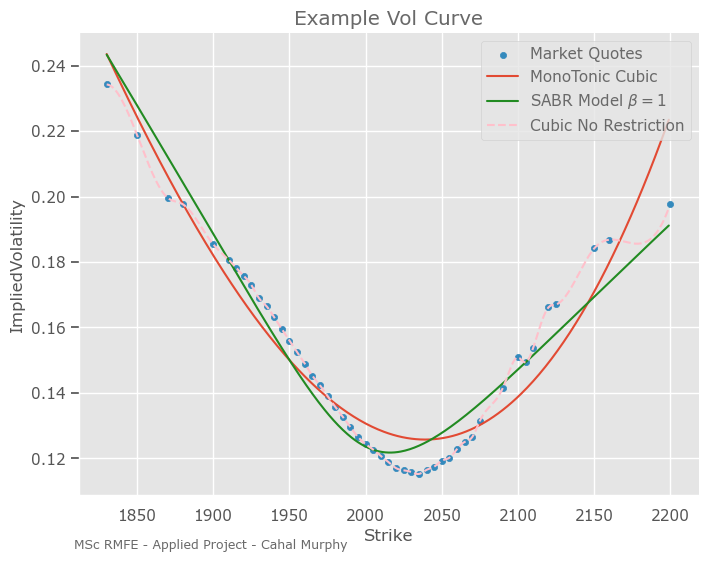

In [41]:
# with plt.style.context('ggplot'):
#     fig, ax = plt.subplots(figsize=(8, 6))
#
#     calls[['Strike', 'ImpliedVolatility']].plot(kind='scatter', x='Strike', y='ImpliedVolatility', ax=ax, label="Market Quotes")
#     ax.plot(k_range, cubic_vols, label="MonoTonic Cubic")
#     ax.plot(k_range, sabr_vols, label=r"SABR Model $\beta=1$", color='forestgreen')
#     ax.plot(k_range, cubic_vols_nonmon, label="Cubic No Restriction", color='pink', ls='--')
#     #ax.axvline(fwd)
#     ax.legend(loc='upper right');
#     ax.set_title("Example Vol Curve");
#     fig.text(0.29, 0.02, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "SampleCurve.png"), bbox_inches="tight")


In [42]:
k_new = np.arange(start=int(calls.Strike.values.min()*.9), stop=int(calls.Strike.values.max()*1.2), step=1)

pdfsabr = tempSABR.construct_pdf(min_strike=int(calls.Strike.values.min()*.9),
                                 max_strike=int(calls.Strike.values.max()*1.2),
                                 fwd=fwd, tenor=tenor, rate=rate,
                                 vol_func_arg=vol_func_arg)
pdfcubic = tempCubic.construct_pdf_cubic(min_strike=int(calls.Strike.values.min()*.9),
                                 max_strike=int(calls.Strike.values.max()*1.2),
                                 fwd=fwd, tenor=tenor, rate=rate)



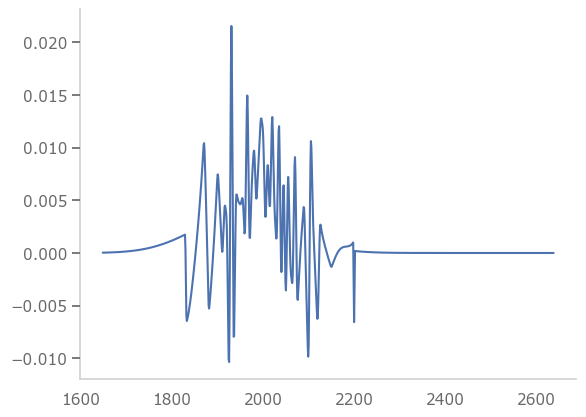

In [43]:

call_prices_interp = black_scholes_formula.black_scholes_call(S=fwd,
                                                             K=k_new,
                                                             sigma=cubic_fit(k_new),
                                                             t=tenor, r=rate)

first_deriv = np.gradient(call_prices_interp, k_new, edge_order=0)
second_deriv = np.gradient(first_deriv, k_new, edge_order=0)
densities = np.exp(-rate*tenor)*second_deriv

# plt.plot(k_new, densities)


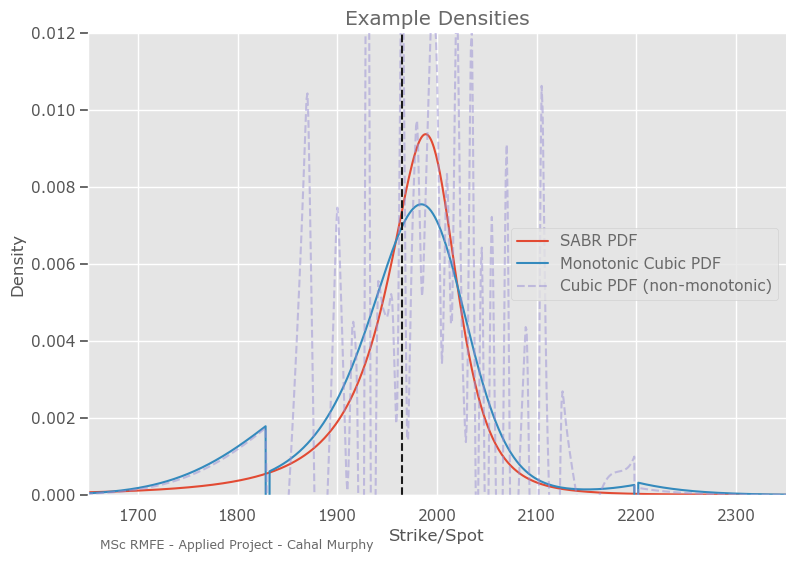

In [54]:
# k_range= np.arange(start=int(calls.Strike.values.min()*.9), stop=int(calls.Strike.values.max()*1.2), step=1)
# k_range2 = np.arange(start=int(calls.Strike.values.min()), stop=int(calls.Strike.values.max()), step=1)
# with plt.style.context('ggplot'):
#     fig, ax = plt.subplots(figsize=(9,6))
#
#     col="slategrey"
#     ax.set_xlabel('Strike')
#     # ax.set_ylabel('Call price', color=col)
#     ax.plot(k_new, pdfsabr, label="SABR PDF")
#     ax.plot(k_new, pdfcubic, label="Monotonic Cubic PDF")
#     ax.plot(k_new, densities, label="Cubic PDF (non-monotonic)", alpha=0.5, ls='--')
#     ax.set_ylim((0, 0.012))
#     ax.set_xlim((1650, 2350))
#     ax.legend();
#     # ax.tick_params(axis='y', labelcolor=col)
#     ax.axvline(fwd, color="k", linestyle="--")
#     ax.set_xlabel("Strike/Spot")
#     ax.set_ylabel("Density");
#     ax.set_title("Example Densities")
#     fig.text(0.29, 0.02, sub_text,
#              wrap=True, horizontalalignment='center', fontsize=9);
#     plt.savefig(os.path.join(output_folder, "SamplePDF.png"), bbox_inches="tight")

* ## Result Table

In [57]:
rnd_avg_year = df_result.groupby(["Year"], as_index=True).agg(avgRNDArea=pd.NamedAgg("RNDArea", aggfunc='mean'))
#rnd_avg_year_month.columns = rnd_avg_year_month.columns.map(month_map)
avg_priceerror_year = df_result.groupby(["Year"], as_index=True).agg(avgPriceError=pd.NamedAgg("AvgCallPriceError", aggfunc='mean'))
# avg_priceerror_yearmonth.columns =avg_priceerror_yearmonth.columns.map(month_map)

In [65]:
rnd_avg_year_cubic = df_result_cubic.groupby(["Year"], as_index=True).agg(avgRNDArea=pd.NamedAgg("RNDArea", aggfunc='mean'))

avg_priceerror_year_cubic = df_result_cubic.groupby(["Year"], as_index=True).agg(avgPriceError=pd.NamedAgg("AvgCallPriceError", aggfunc='mean'))

In [76]:
result_table = pd.concat([rnd_avg_year, avg_priceerror_year, rnd_avg_year_cubic,avg_priceerror_year_cubic], ignore_index=False, axis=1)

In [81]:
result_table.columns = pd.MultiIndex.from_product([('SABR', 'Cubic'), ['avgRNDArea', 'avgPriceError'],])

In [92]:
# print(result_table.to_latex())

### Sampling

In [46]:
# cdf = np.cumsum(d)
# '''
# Step 2: Sample uniform random numbers
# '''
# N = 10000
# U = np.random.uniform(0, 1, N)
#
#
# '''
# Step 3: Generate Samples from Inverse CDF:
# '''
# event_value = np.arange(row.min_strike, row.max_strike, 0.01)
# sample_x = [event_value[ np.argwhere(cdf == min(cdf[(cdf - u) > 0])).item() ]for u in U]
#
#
# '''
# Step 4: Comparison
# '''
# # sample_x = (np.array(sample_x)-1)
# # times = np.arange(0,6,1)
# # lc = np.bincount(sample_x, minlength=len(times))
# #
# # plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Sampled events')
# # plot2, = plt.plot(d,'g',label='Original data')
# # plt.xlabel('Event Value')
# # plt.ylabel('Probability')
# # plt.legend(handles=[plot1,plot2])

ValueError: min() arg is an empty sequence

In [ ]:
# plt.hist(sample_x, density=True)
# plt.plot(event_value, d*100)

In [ ]:
# [np.quantile(sample_x, q=quantile/100) for quantile in range(5, 100, 5)]

#### Fan Chart Test Idea

In [ ]:
# #df_ = pd.DataFrame(index=["1", "2", "3"], columns=["Quantile {}".format(q/100)  for q in range(5, 20, 5)])
# df_ = pd.DataFrame(index=["1", "2", "3"], columns=["A", "B", "C"])

In [ ]:
# df_["B"] = np.arange(1, 4, 1)
# df_["A"] = df_["B"]*0.75
# df_["C"] = df_["B"]*1.25

In [ ]:
# df_.plot()
# plt.fill_between(x=df_.index, y1=df_["A"], y2=df_["B"], color='pink', label='quantile example')
# plt.fill_between(x=df_.index, y1=df_["B"], y2=df_["C"], color='cyan', label='quantile example2')
#
# # can also just use seaborn!!
# # for interval in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
# #     plot = sns.lineplot(df, estimator="median", errorbar=("pi", interval), col